# <font size=40 color='blue'> Homework04 of course Computational Geophysics </font>

# 1. 1D static elastice problem

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

# 1D static elastic problem with 2-order for space finite difference method
def FDM1D(nx, sx, mu, x0, nit):
    u = np.zeros(nx)
    x = np.linspace(0, x0, nx)
    dx = x[1] - x[0]
    f = np.zeros(nx)
    f[sx] = 1 / dx
    du = np.zeros(nx)
    for j in range(nit):
        u[0] = 1
        u[nx-1] =2
        for i in range(1, (nx-1)):
            du[i] = u[i+1] + u[i-1]
        u[1: nx-1] = (du[1: nx-1] + f[1: nx-1]*dx**2/mu) / 2
    return x, u

# 1D static elastic problem with finite element metthod.
def FEM1D(nx, sx, mu, x0):
    u = np.zeros(nx)
    f = np.zeros(nx)
    x = np.linspace(0, x0, nx)
    dx = x[1] - x[0]
    K = np.zeros((nx, nx))
    K[0, 0] = mu / dx
    K[nx-1, nx-1] = mu / dx
    for i in range(1, nx-1):
        for j in range(1, nx-1):
            if i == j:
                K[i, j] = 2 * mu / dx
            elif i == (j+1):
                K[i, j] = -mu / dx
            elif (1+i) == j:
                K[i, j] = -mu / dx
            else:
                K[i, j] = 0.
    f[sx] = 1          
    u[0] = 1
    f[1] = u[0] / dx
    u[nx-1] = 2
    f[nx-2] = u[nx-1] / dx
    u[1: (nx-1)] = inv(K[1: (nx-1), 1: (nx-1)]) @ f[1: (nx-1)].T
    return x, u

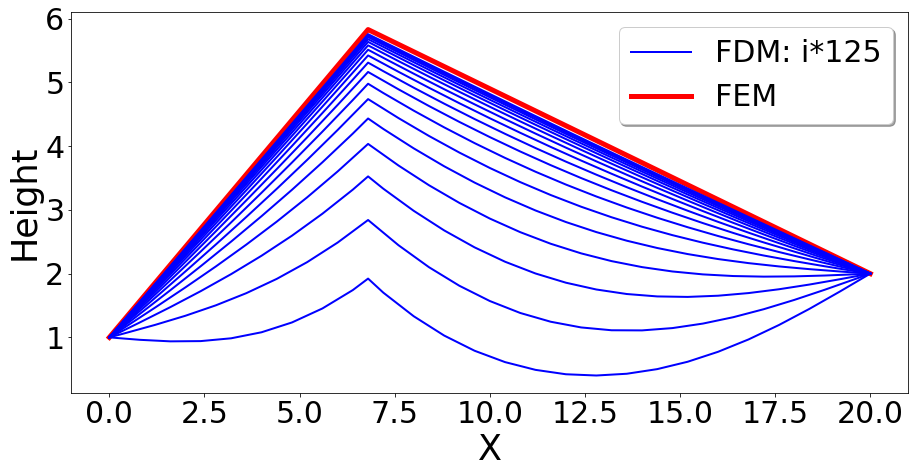

In [100]:
x0 = 20
nx = 51
sx = nx // 3
mu = 1
nit = 2000
x1, u1 = FDM1D(nx, sx, mu, x0, nit)
x2, u2 = FEM1D(nx, sx, mu, x0)
tt = 125
ti = nit // tt
plt.figure(figsize=(15, 7))
plt.plot(x1, u1, lw=2, color='b',label='FDM: i*125')
plt.plot(x2, u2, lw=5, color='r', label='FEM')
for i in range(ti+1):
    x, u = FD(nx, sx, mu, x0, i*tt+tt)
    plt.plot(x, u, lw=2, color='b')

plt.legend(fontsize=30, shadow=True)
plt.xlabel('X', fontsize=35)
plt.ylabel('Height', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

## FEM can solve this static problem perfectly (red solid line in figure above), but FDM have to iterate this procedures for many times, here, up to 2000 times (blue solid lines for every 125 iterations in figure above).

***
***
***
# 2. 1-D elastic wave propagation modeling

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

# 1D elastic wave modeling with finite element method.
def FEMEW1D(nt, dt, nx, sx, x0, f0, ro, vs):
    mu = vs**2 * ro
    x = np.linspace(0, x0, nx)
    dx = x[1] - x[0]
    M = np.zeros((nx, nx))
    u = np.zeros((nt, nx))
    K = np.zeros_like(M)
    for i in range(1, nx-1):
        for j in range(1, nx-1):
            if i == j:
                M[i, j] = 2/3 * ro*dx
                K[i, j] = 2*mu/dx
            elif (i+1) == j or (i-1) == j:
                M[i, j] = ro*dx / 6
                K[i, j] = -mu / dx
            else:
                M[i, j] = 0
                K[i, j] = 0
    M[0, 0] = ro*dx/3
    M[nx-1, nx-1] = ro*dx/3
    K[0, 0] = mu / dx
    K[nx-1, nx-1] = mu / dx
    
    t = np.arange(nt) * dt
    f = np.zeros(nx)
    f[sx] = 1.
    s = (1-2*(np.pi*f0*(t-1/f0))**2) * np.exp(-(np.pi*f0*(t-1/f0))**2)
    IM = inv(M.T)
    for i in range(1, nt-1):
        u[i+1] = dt**2 * IM @ (f.T*s[i]-K.T@u[i].T) + 2*u[i] - u[i-1]
    return x, t, u

# 1D elastic wave modeling with 2-order for space finite difference method.
def FDM221D(nt, dt, nx, sx, x0, f0, ro, vs):
    mu = vs**2 * ro
    x = np.linspace(0, x0, nx)
    dx = x[1] - x[0]
    t = np.arange(nt) * dt
    u = np.zeros((nt, nx))
    s = (1-2*(np.pi*f0*(t-1/f0))**2) * np.exp(-(np.pi*f0*(t-1/f0))**2)
    f = np.zeros_like(s)
    f[sx] = 1.
    print(nt)
    for i in range(1, nt-1):
        for j in range(1, nx-1):
            u[i+1, j] = 2*u[i, j] - u[i-1, j] + ((u[i, j+1]-2*u[i, j]+u[i, j-1])/dx/dx*mu + f[j]/dx*s[i])/ro*dt*dt
    return x, t, u

751


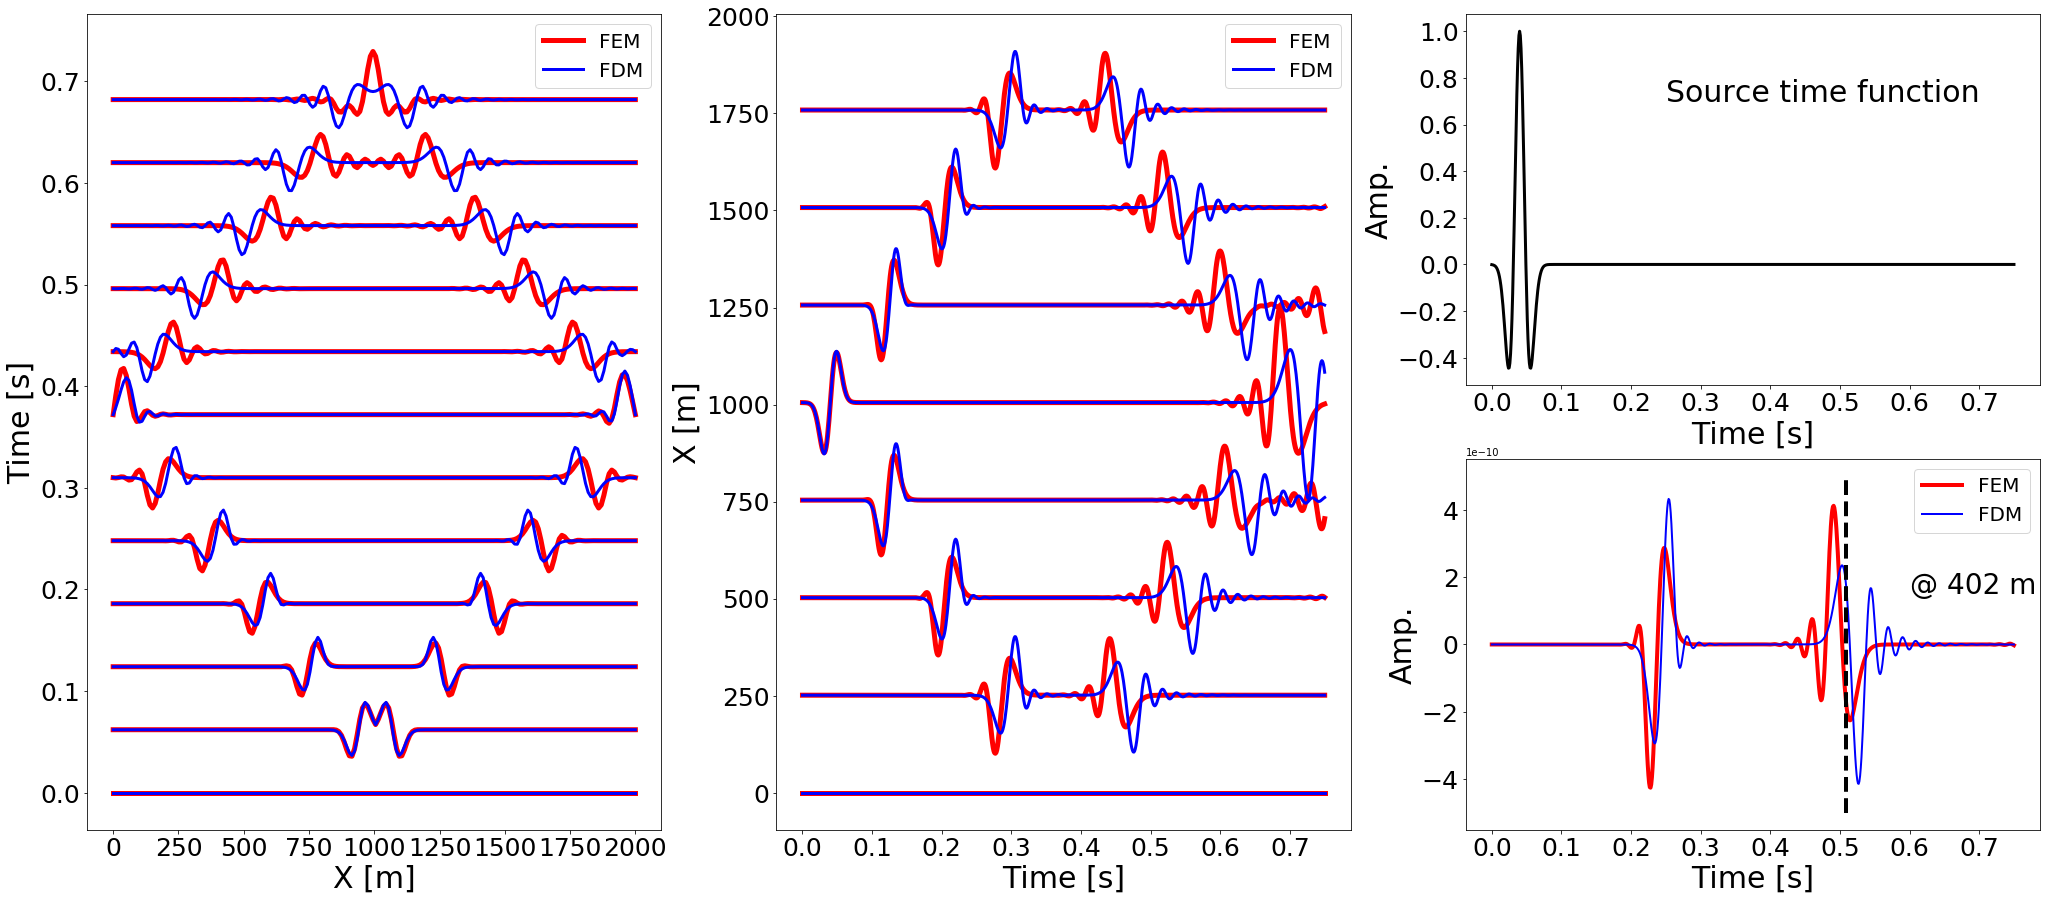

In [49]:
nt = 751
dt = 0.001
nx = 200
x0 = 2000.
ro = 2500.
vs = 3000.
dx = x0 / (nx-1)
sx = nx // 2
f0 = 25
vs = 3000
t = np.arange(nt) * dt
s = (1-2*(np.pi*f0*(t-1/f0))**2) * np.exp(-(np.pi*f0*(t-1/f0))**2)
ti = 12
tt = nt // ti
x1, t1, u1 = FEMEW1D(nt, dt, nx, sx, x0, f0, ro, vs)
x2, t2, u2 = FDM221D(nt, dt, nx, sx, x0, f0, ro, vs)
plt.figure(figsize=(35, 15))
plt.subplot(131)
for i in range(ti):
    d1 = u1[i*tt] * 7e7
    d2 = u2[i*tt] * 7e7
    if i < 1:
        plt.plot(x1, d1+i*tt*dt, lw=5, color='r', label='FEM')
        plt.plot(x2, d2+i*tt*dt, lw=3, color='b', label='FDM')
    else:
        plt.plot(x1, d1+i*tt*dt, lw=5, color='r')
        plt.plot(x2, d2+i*tt*dt, lw=3, color='b')
plt.xlabel('X [m]', fontsize=30)
plt.ylabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)

plt.subplot(132)
xx = 25
xi = nx // xx
for i in range(xi):
    d1 = u1[:, i*xx] * 3.5e11
    d2 = u2[:, i*xx] * 3.5e11
    if i < 1:
        plt.plot(t1, d1+i*xx*dx, lw=5, color='r', label='FEM')
        plt.plot(t2, d2+i*xx*dx, lw=3, color='b', label='FDM')
    else:
        plt.plot(t1, d1+i*xx*dx, lw=5, color='r')
        plt.plot(t2, d2+i*xx*dx, lw=3, color='b')
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('X [m]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)

plt.subplot(233)
plt.plot(t, s, lw=3, color='k')
plt.text(t[nt//3], 0.7, 'Source time function', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Amp.', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.subplot(236)
xii = nx // 5
t0 = 1/f0 + (abs(xii-sx)*dx+xii*dx*2)/vs
plt.plot(t1, u1[:, xii], color='r', lw=4, label='FEM', zorder=0)
plt.plot(t2, u2[:, xii], color='b', lw=2, label='FDM', zorder=1)
plt.text(0.6, 1.5e-10, '@ %.0f m'%(dx*(xii)), fontsize=28, zorder=2)
plt.plot([t0, t0], [-5e-10, 5e-10], lw=4, color='k', ls='--', zorder=5)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Amp.', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.savefig('Elastic_Wave_1D.png', dpi=150)
plt.show()

***
***
***
# 3. Stability and numerical anisotropy analysis for 2D acoustic wave modeling.

## 3.1 Spatial sampling ratio between "X" and "Z" directions and propagation direction.

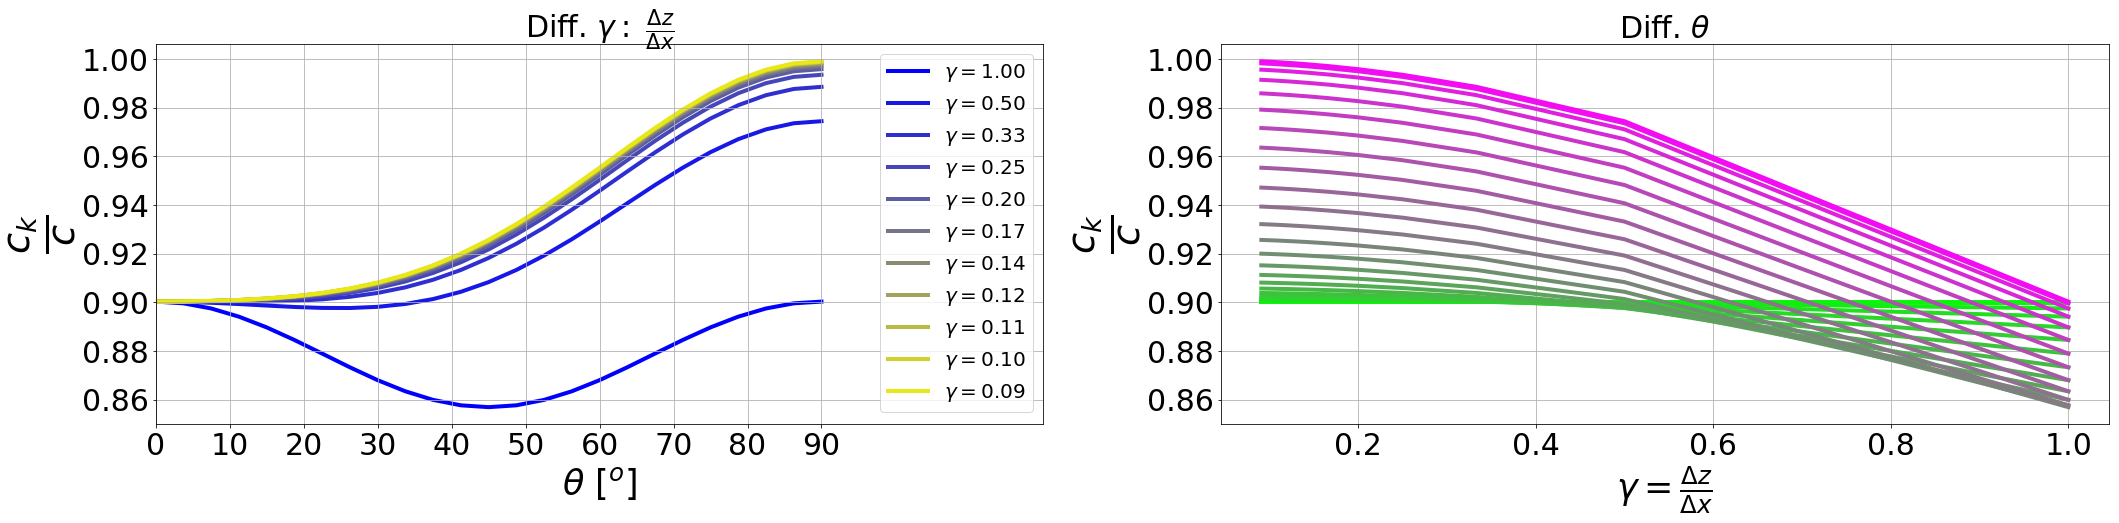

In [3]:
import numpy as np
import matplotlib.pyplot as plt

m = 11
n = 25
dx = np.linspace(1, 11, m)
dz = 1
gamma = dz / dx
f = 30
c = 2000
k = np.pi/dx*0.5
ck = np.zeros((m, n))
theta = np.linspace(0, np.pi/2, n)
mm = 1 / m
nn = 1 / n
for i in range(m):
    f1 = np.cos(k[i]*dx[i]*(np.cos(theta)+gamma[i]*np.sin(theta)))
    f2 = np.cos(k[i]*dx[i]*(np.cos(theta)-gamma[i]*np.sin(theta)))
    f3 = np.cos(k[i]*dx[i]*gamma[i]*np.sin(theta))
    f4 = np.cos(k[i]*dx[i]*np.cos(theta))
    ck[i] = 3**0.5/(3*gamma[i]*k[i]*dx[i]) * (4*(gamma[i]**2+1)-\
            (gamma[i]**2+1)*(f1+f2)+2*(gamma[i]**2-2)*f3-2*(2*gamma[i]**2-1)*f4)**0.5
    
plt.figure(figsize=(35, 7))
plt.subplot(121)
for i in range(m):
    plt.plot(theta/np.pi*180, ck[i], lw=4, color=[mm*i, mm*i, 1-mm*i], \
             zorder=0, label=r'$\gamma=$%.2f'%gamma[i])
plt.xlabel(r'$\theta \ [^o]$', fontsize=35)
plt.ylabel(r'$\frac{c_k}{c}$', fontsize=55)
plt.xticks(np.linspace(0, 90, 10), fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(0, 120)
plt.grid(True)
plt.legend(fontsize=20)
plt.title(r'Diff. $\gamma: \ \frac{\Delta z}{\Delta x}$', fontsize=30)

plt.subplot(122)
for i in range(n):
    plt.plot(gamma, ck[:, i], lw=4, color=[nn*i, 1-nn*i, nn*i], zorder=2)
plt.xlabel(r'$\gamma=\frac{\Delta z}{\Delta x}$', fontsize=35)
plt.ylabel(r'$\frac{c_k}{c}$', fontsize=55)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.title(r'Diff. $\theta$', fontsize=30)
plt.show()

In [33]:
def get_colors(fname):
    c = []
    with open(fname, 'r') as fin:
        for line in fin.readlines():
            line = line.strip()
            c.append(line)
    return c

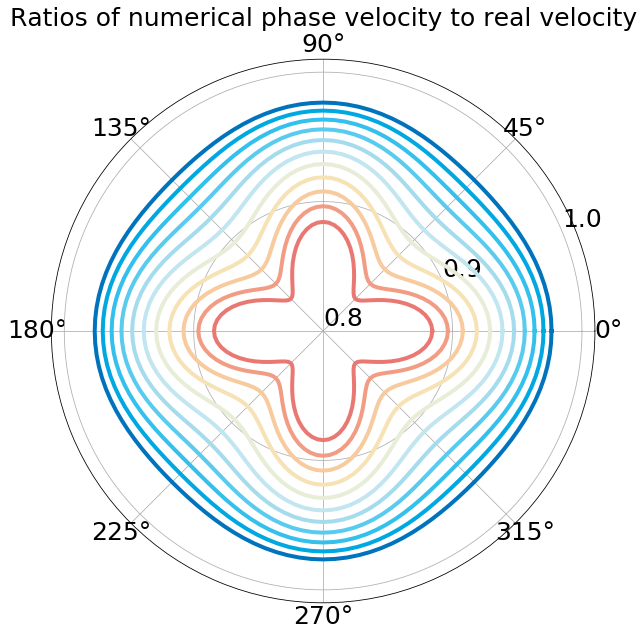

In [51]:
import numpy as np
import matplotlib.pyplot as plt

fname = r'../Homework03_11930721_bak_20191022/Dir_cmap_python/cmap_01.txt'
colors = get_colors(fname)
m = 11
n = 121
dx = 1
ks = 1 / dx
gamma = 1.
dz = dx * gamma
f = 30
c = 2000
k = 2*np.pi/dx * np.linspace(0.12, 0.27, m)
ck = np.zeros((m, n))
theta = np.linspace(0, 2*np.pi, n)
mm = 1 / m
nn = 1 / n
for i in range(m):
    f1 = np.cos(k[i]*dx*(np.cos(theta)+gamma*np.sin(theta)))
    f2 = np.cos(k[i]*dx*(np.cos(theta)-gamma*np.sin(theta)))
    f3 = np.cos(k[i]*dx*gamma*np.sin(theta))
    f4 = np.cos(k[i]*dx*np.cos(theta))
    ck[i] = 3**0.5/(3*gamma*k[i]*dx) * (4*(gamma**2+1)-\
            (gamma**2+1)*(f1+f2)+2*(gamma**2-2)*f3-2*(2*gamma**2-1)*f4)**0.5
    
plt.figure(figsize=(10, 10))
plt.subplot(111, projection='polar')
for i in range(m):
    plt.plot(theta, ck[i], lw=4, color=colors[i])
plt.xticks(fontsize=25)
plt.yticks([0.8, 0.9, 1.0], fontsize=25)
plt.grid(True)
plt.ylim(0.8, 1.01)
# plt.legend(fontsize=20)
plt.title(r'Ratios of numerical phase velocity to real velocity', fontsize=25)
plt.savefig('Homework04/Numerical_Dispersion_Fig.png')
plt.show()


##                         where Ck is numerical phase volocity and C is the given real velocity.
***

## 3.2 Spatial sampling.

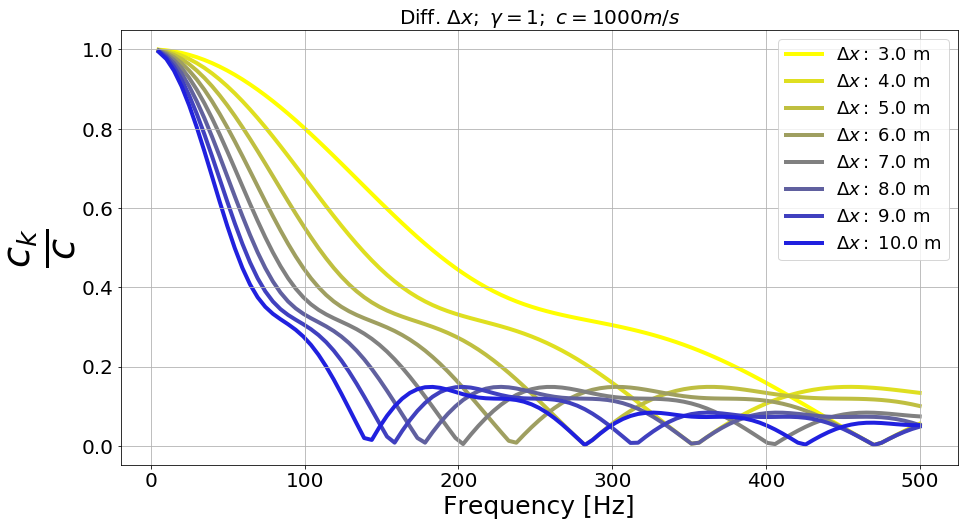

In [6]:
import numpy as np
import matplotlib.pyplot as plt

m = 8
n = 101
dx = np.linspace(3, 10, m)
gamma  = 1
dy = dx * gamma
f = np.linspace(5, 500, n)
c = 1000
k = 2*np.pi*f / c
ck = np.zeros((m, n))
theta = np.pi / 4
mm = 1 / m
nn = 1 / n
for i in range(m):
    f1 = np.cos(k*dx[i]*(np.cos(theta)+gamma*np.sin(theta)))
    f2 = np.cos(k*dx[i]*(np.cos(theta)-gamma*np.sin(theta)))
    f3 = np.cos(k*dx[i]*gamma*np.sin(theta))
    f4 = np.cos(k*dx[i]*np.cos(theta))
    ck[i] = 3**0.5/(3*gamma*k*dx[i]) * (4*(gamma**2+1)-\
            (gamma**2+1)*(f1+f2)+2*(gamma**2-2)*f3-2*(2*gamma**2-1)*f4)**0.5

plt.figure(figsize=(15, 8))
for i in range(m):
    plt.plot(f, ck[i], lw=4, color=[1-mm*i, 1-mm*i, mm*i], \
             label='$\Delta x:$ %.1f m' %dx[i], zorder=0)
plt.xlabel(r'Frequency [Hz]', fontsize=25)
plt.ylabel(r'$\frac{c_k}{c}$', fontsize=55)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=18)
plt.title(r'Diff. $\Delta x; \ \gamma=1; \ c = 1000 m/s$', fontsize=20)
plt.show()

## 3.3 Acoustic wave propagation velocity

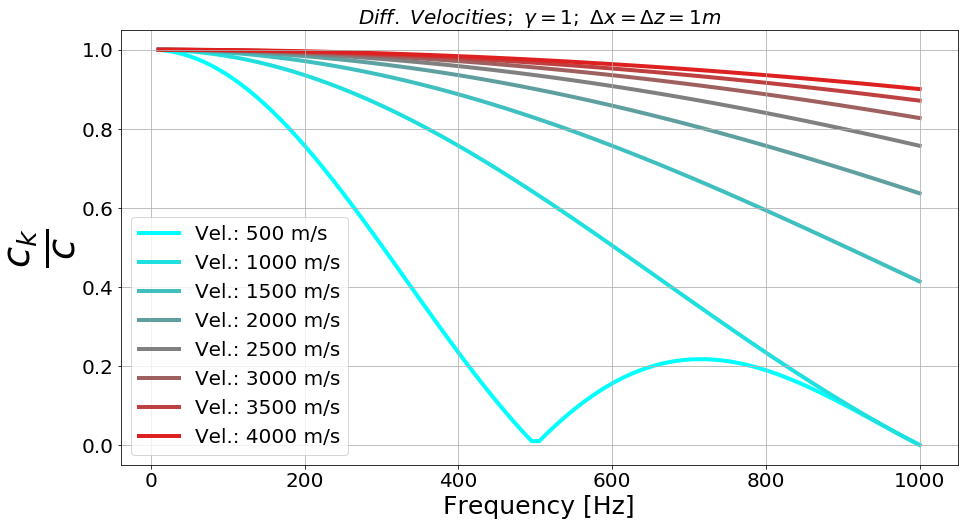

In [152]:
import numpy as np
import matplotlib.pyplot as plt

m = 8
n = 101
dx = 1
gamma  = 1
dy = dx * gamma
f = np.linspace(10, 1000, n)
c = np.linspace(500, 4000, m)
ck = np.zeros((m, n))
theta = np.pi / 2
mm = 1 / m
nn = 1 / n
for i in range(m):
    k = 2*np.pi * f / c[i]
    f1 = np.cos(k*dx*(np.cos(theta)+gamma*np.sin(theta)))
    f2 = np.cos(k*dx*(np.cos(theta)-gamma*np.sin(theta)))
    f3 = np.cos(k*dx*gamma*np.sin(theta))
    f4 = np.cos(k*dx*np.cos(theta))
    ck[i] = 3**0.5/(3*gamma*k*dx) * (4*(gamma**2+1)-\
            (gamma**2+1)*(f1+f2)+2*(gamma**2-2)*f3-2*(2*gamma**2-1)*f4)**0.5

plt.figure(figsize=(15, 8))
for i in range(m):
    plt.plot(f, ck[i], lw=4, color=[mm*i, 1-mm*i, 1-mm*i], \
             label='Vel.: %.0f m/s' %c[i], zorder=0)
plt.xlabel(r'Frequency [Hz]', fontsize=25)
plt.ylabel(r'$\frac{c_k}{c}$', fontsize=55)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.title(r'$Diff. \ Velocities; \ \gamma=1; \ \Delta x=\Delta z = 1m$', fontsize=20)

plt.show()

# 4. 2D acoustic wave propagation modeling with finite element method.

## 4.1 4-node Quadrilateral Element and bilinear 2D shape functions

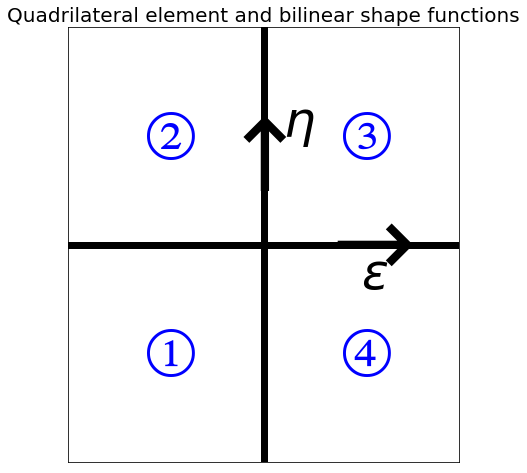

In [148]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 8))
plt.plot([0, 0], [-1, 1], lw=7, color='k')
plt.plot([-1, 1], [0, 0], lw=7, color='k')
plt.text(-0.6, -0.6, r'$\circled{1}$', fontsize=70, color='b')
plt.text(-0.6, 0.4, r'$\circled{2}$', fontsize=70, color='b')
plt.text(0.4, 0.4, r'$\circled{3}$', fontsize=70, color='b')
plt.text(0.4, -0.6, r'$\circled{4}$', fontsize=70, color='b')
plt.text(0.5, -0.2, r'$\epsilon$', fontsize=50)
plt.text(0.1, 0.5, r'$\eta$', fontsize=50)

plt.text(0.25, -0.135, r'$\rightarrow$', fontsize=100)
plt.text(-0.312, 0.25, r'$\uparrow$', fontsize=100)
plt.xticks([])
plt.yticks([])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Quadrilateral element and bilinear shape functions', fontsize=20)
plt.show()

## 4.2 Formulas of bilinear shape functions.
$$
\Large{
    \epsilon \in [-1, 1]\\
    \eta \in [-1, 1]
}
$$
$$
\huge{
    N_1 = \frac{1}{4}(1-\epsilon)(1-\eta)\\
    N_2 = \frac{1}{4}(1-\epsilon)(1+\eta)\\
    N_3 = \frac{1}{4}(1+\epsilon)(1+\eta)\\
    N_4 = \frac{1}{4}(1+\epsilon)(1-\eta)
}
$$

In [28]:
import numpy as np

def KMElement(dx, dz, c):
    # Finding element mass matrix and stiffness matrix
    gamma = dz / dx
    Ke = np.zeros((4, 4))
    Me = np.zeros((4, 4))
    for i in range(4):
        Me[i, i] = 1.
        Ke[i, i] = gamma + 1./ gamma
    
    Ke[0, 1] = gamma/2.-1./gamma; Ke[0, 2] = -0.5*(gamma+1./gamma); Ke[0, 3] = 1./(2.*gamma)-gamma
    Ke[1, 0] = Ke[0, 1];  Ke[1, 2] = 1./(2.*gamma)-gamma;  Ke[1, 3] = -0.5*(gamma+1./gamma)
    Ke[2, 0] = Ke[0, 2];  Ke[2, 1] = Ke[1, 2];    Ke[2, 3] = gamma/2.-1./gamma
    Ke[3, 0] = Ke[0, 3];  Ke[3, 1] = Ke[1, 3];    Ke[3, 2] = Ke[2, 3]
    
    Me = (dx*dz/4.) * Me
    Ke = (c**2/3.) * Ke
    return Me, Ke

def KMGlobal(nz, Me, Ke):
    # Finding global mass matrix and stiffness matrix.
    K = np.zeros((nz**2, nz**2))
    M = np.zeros_like(K)
    for i in range(nz*nz):
        # 1. Lower left  corner
        if i == 0:
            K[i, i] = Ke[0, 0]; K[i, i+1] = Ke[0, 3]; K[i, i+nz] = Ke[0, 1]; K[i, i+nz+1] = Ke[0, 2]
            M[i, i] = Me[0, 0]; M[i, i+1] = Me[0, 3]; M[i, i+nz] = Me[0, 1]; M[i, i+nz+1] = Me[0, 2]
        # 2. Lower right corner
        elif (i+1) == nz:
            K[i, i-1] = Ke[3, 0]; K[i, i] = Ke[3, 3]; K[i, i+nz-1] = Ke[3, 1]; K[i, i+nz] = Ke[3, 2]
            M[i, i-1] = Me[3, 0]; M[i, i] = Me[3, 3]; M[i, i+nz-1] = Me[3, 1]; M[i, i+nz] = Me[3, 2]
        # 3. Upper left corner
        elif i == (nz-1)*nz:           
            K[i, i-nz] = Ke[1, 0]; K[i, i-nz+1] = Ke[1, 3]; K[i, i] = Ke[1, 1]; K[i, i+1] = Ke[1, 2]
            M[i, i-nz] = Me[1, 0]; M[i, i-nz+1] = Me[1, 3]; M[i, i] = Me[1, 1]; M[i, i+1] = Me[1, 2]
        # 4. Upper right corner
        elif i == (nz*nz-1):
            K[i, i-nz-1] = Ke[2, 0]; K[i, i-nz] = Ke[2, 3]; K[i, i-1] = Ke[2, 1]; K[i, i] = Ke[2, 2]
            M[i, i-nz-1] = Me[2, 0]; M[i, i-nz] = Me[2, 3]; M[i, i-1] = Me[2, 1]; M[i, i] = Me[2, 2]
        # 5. Lower row
        elif i > 0 and i < (nz-1):
            K[i, i-1] = Ke[3, 0]; K[i, i] = Ke[0, 0] + Ke[3, 3]; K[i, i+1] = Ke[0, 3]; 
            K[i, i+nz-1] = Ke[3, 1]; K[i, i+nz] = Ke[0, 1] + Ke[3, 2]; K[i, i+nz+1] = Ke[0, 2]
            
            M[i, i-1] = Me[3, 0]; M[i, i] = Me[0, 0] + Me[3, 3]; M[i, i+1] = Me[0, 3]; 
            M[i, i+nz-1] = Me[3, 1]; M[i, i+nz] = Me[0, 1] + Me[3, 2]; M[i, i+nz+1] = Me[0, 2]
        # 6. Left column
        elif i > 0 and i < (nz-1)*nz and i%nz == 0:
            K[i, i-nz] = Ke[1, 0]; K[i, i-nz+1] = Ke[1, 3]; K[i, i] = Ke[0, 0] + Ke[1, 1]; 
            K[i, i+1] = Ke[1, 2] + Ke[0, 3]; K[i, i+nz] = Ke[0, 1]; K[i, i+nz+1] = Ke[0, 2]
            
            M[i, i-nz] = Me[1, 0]; M[i, i-nz+1] = Me[1, 3]; M[i, i] = Me[0, 0] + Me[1, 1]; 
            M[i, i+1] = Me[1, 2] + Me[0, 3]; M[i, i+nz] = Me[0, 1]; M[i, i+nz+1] = Me[0, 2]
        # 7. Upper row
        elif i > (nz-1)*nz and i < (nz*nz-1):
            K[i, i-nz-1] = Ke[2, 0]; K[i, i-nz] = Ke[1, 0] + Ke[2, 3]; K[i, i-nz+1] = Ke[1, 3]; 
            K[i, i-1] = Ke[2, 1]; K[i, i] = Ke[1, 1] + Ke[2, 2]; K[i, i+1] = Ke[1, 2]
            
            M[i, i-nz-1] = Me[2, 0]; M[i, i-nz] = Me[1, 0] + Me[2, 3]; M[i, i-nz+1] = Me[1, 3]; 
            M[i, i-1] = Me[2, 1]; M[i, i] = Me[1, 1] + Me[2, 2]; M[i, i+1] = Me[1, 2]
        # 8. Right column
        elif i > nz and i < (nz-1)*nz and (i+1) % nz == 0:
            K[i, i-nz-1] = Ke[2, 0]; K[i, i-nz] = Ke[2, 3]; K[i, i-1] = Ke[3, 0] + Ke[2, 1]; 
            K[i, i] = Ke[2, 2] + Ke[3, 3]; K[i, i+nz-1] = Ke[3, 1]; K[i, i+nz] = Ke[3, 2]
            
            M[i, i-nz-1] = Me[2, 0]; M[i, i-nz] = Me[2, 3]; M[i, i-1] = Me[3, 0] + Me[2, 1]; 
            M[i, i] = Me[2, 2] + Me[3, 3]; M[i, i+nz-1] = Me[3, 1]; M[i, i+nz] = Me[3, 2]
        # 9. Internal part
        else:
            K[i, i-nz-1] = Ke[2, 0]; K[i, i-nz] = Ke[1, 0] + Ke[2, 3]; K[i, i-nz+1] = Ke[1, 3];
            K[i, i-1] = Ke[3, 0] + Ke[2, 1]; K[i, i] = Ke[0, 0] + Ke[1, 1] + Ke[2, 2] + Ke[3, 3]; 
            K[i, i+1] = Ke[0, 3] + Ke[1, 2]; K[i, i+nz-1] = Ke[3, 1]; 
            K[i, i+nz] = Ke[0, 1] + Ke[3, 2]; K[i, i+nz+1] = Ke[0, 2]
            
            M[i, i-nz-1] = Me[2, 0]; M[i, i-nz] = Me[1, 0] + Me[2, 3]; M[i, i-nz+1] = Me[1, 3];
            M[i, i-1] = Me[3, 0] + Me[2, 1]; M[i, i] = Me[0, 0] + Me[1, 1] + Me[2, 2] + Me[3, 3]; 
            M[i, i+1] = Me[0, 3] + Me[1, 2]; M[i, i+nz-1] = Me[3, 1]; 
            M[i, i+nz] = Me[0, 1] + Me[3, 2]; M[i, i+nz+1] = Me[0, 2]
    # Get lower triangular parts of global matrices.
    K += (K.T - np.diag(K.diagonal()))
    M += (M.T - np.diag(M.diagonal()))
    return M, K

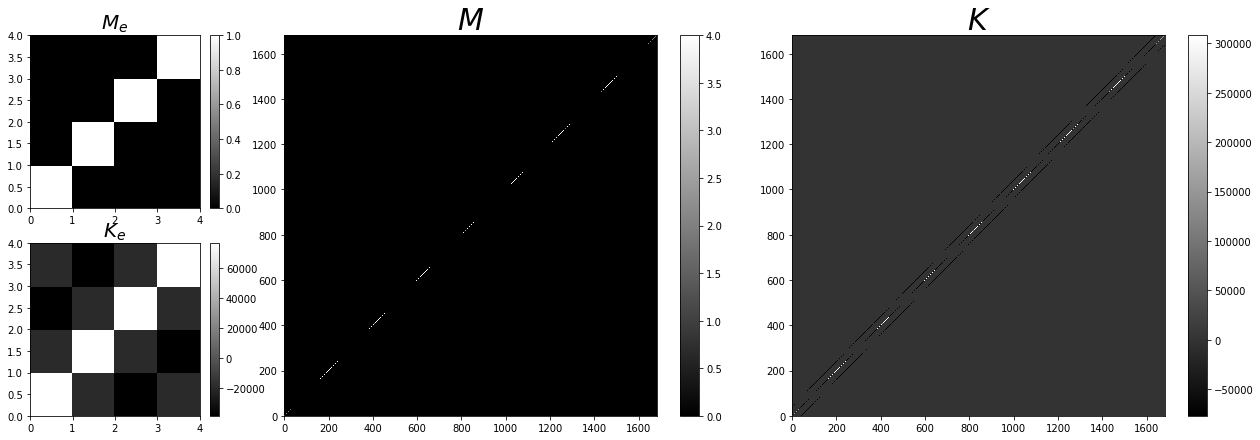

In [29]:
import numpy as np
import matplotlib.pyplot as plt

dx = 2.
dz = 2.
nx = 41
nz = 41
c = 340.
Me, Ke = KMElement(dx, dz, c)
M, K = KMGlobal(nz, Me, Ke)

plt.figure(figsize=(22, 7))
ax1 = plt.subplot2grid((2, 5), (0, 0))
plt.pcolormesh(Me, cmap='gray')
plt.colorbar()
plt.title(r'$M_e$', fontsize=20)
ax2 = plt.subplot2grid((2, 5), (1, 0))
plt.pcolormesh(Ke, cmap='gray')
plt.colorbar()
plt.title(r'$K_e$', fontsize=20)
ax3 = plt.subplot2grid((2, 5), (0, 1), colspan=2, rowspan=2)
plt.pcolormesh(M, cmap='gray')
plt.colorbar()
plt.title(r'$M$', fontsize=30)
ax4 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)
plt.pcolormesh(K, cmap='gray')
plt.colorbar()
plt.title(r'$K$', fontsize=30)
plt.savefig('Global_Matrices.png')
plt.show()

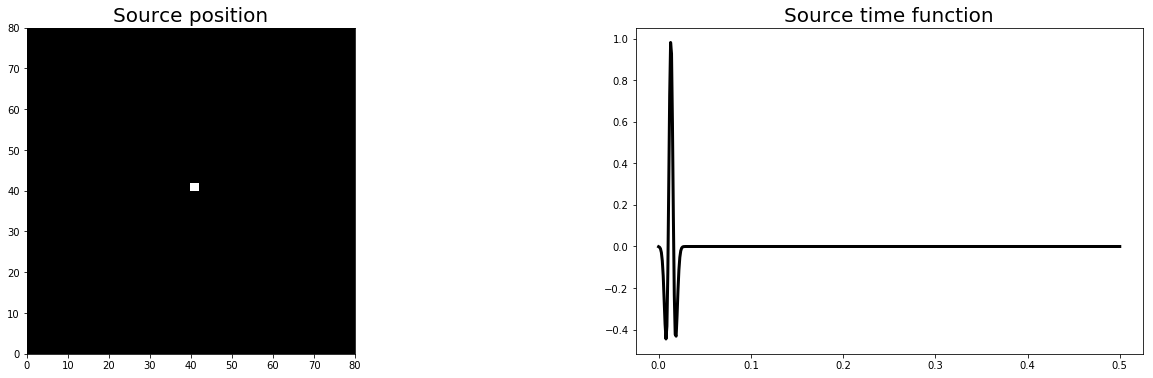

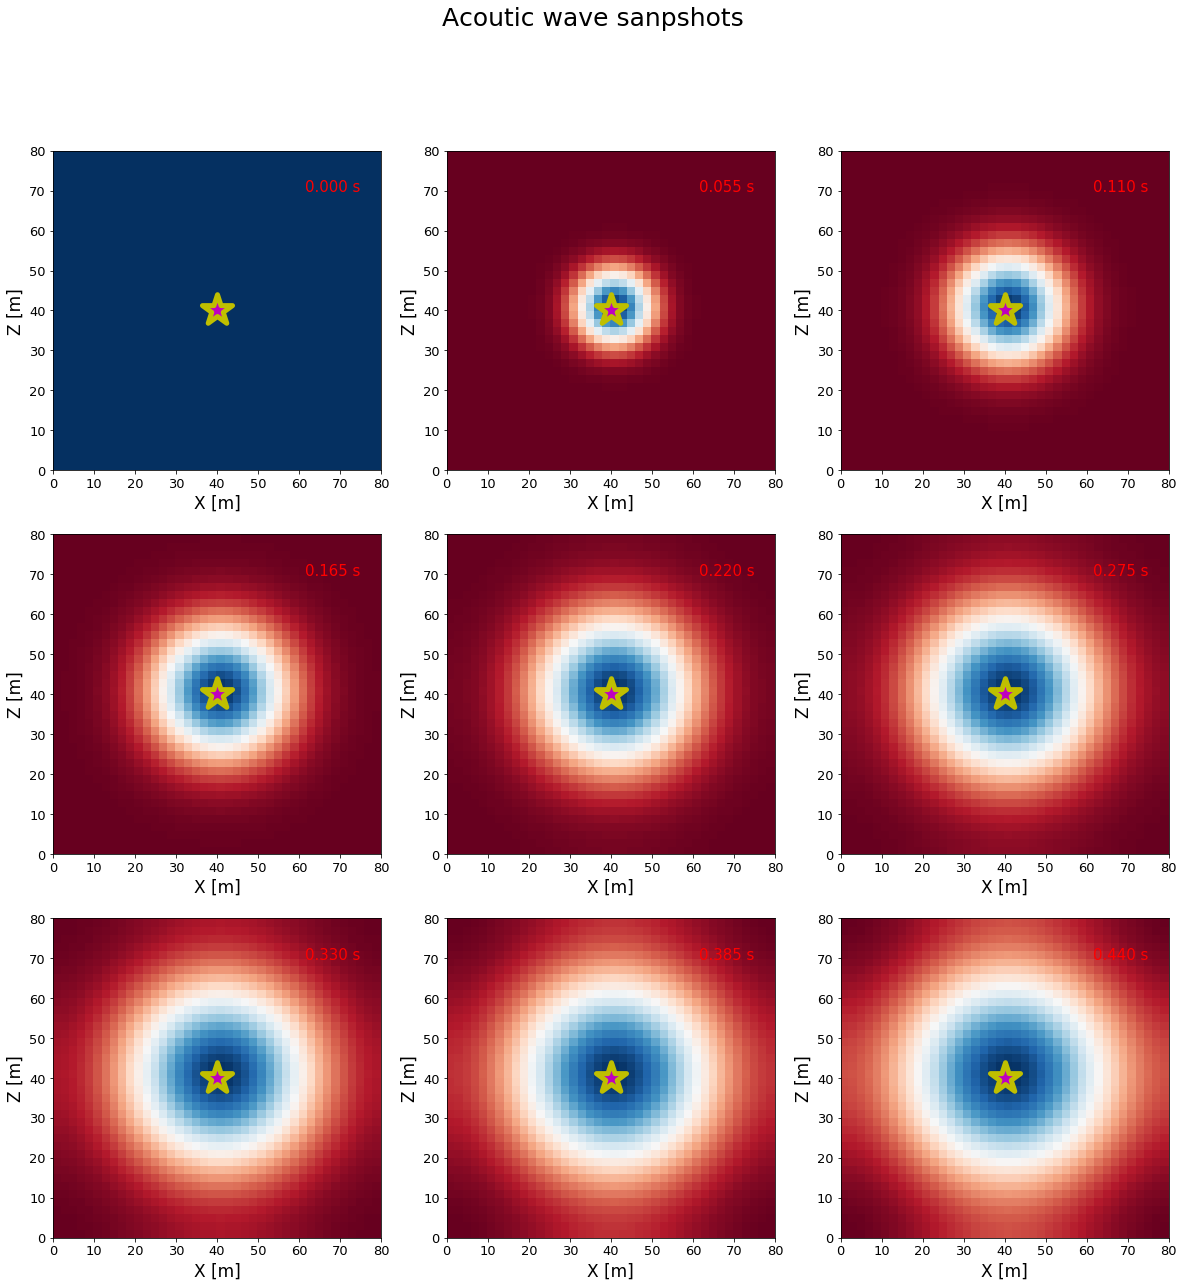

In [30]:
from scipy.linalg import inv

# No. of time points.
nt = 501
# Temporal interval in second.
dt = 0.001
# Center frequency in Hz.
f0 = 75.
x = np.arange(nz) * dx
z = np.arange(nz) * dz
t = np.arange(nt) * dt
# Set position of source.
sx = nx // 2
sz = nz // 2

# Set source, Ricker wavelet.
X, Z = np.meshgrid(x, z)
f = np.zeros((nz, nz))
f[sz, sx] = 1.
# f = np.exp(-((X-sx*dx)**2+(Z-sz*dz)**2)/dx)
f = f.reshape(nz*nz)
s = (1-2*(np.pi*f0*(t-1/f0))**2) * np.exp(-(np.pi*f0*(t-1/f0))**2)
u = np.zeros((nt, nz*nz))

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.pcolormesh(x, z, f.reshape(nz, nz), cmap='gray')
plt.title('Source position', fontsize=20)
plt.subplot(1, 2, 2)
plt.plot(t, s, lw=3, color='k')
plt.title('Source time function', fontsize=20)
plt.show()

# Invert global mass matrix.
INVM = inv(M)
# INVM = np.zeros_like(M)
# for i in range(nz*nz):
#     INVM[i, i] = 1. / M[i, i]
    

# Iterations for finding solutions to acoustic pressure.
for i in range(1, nt-1):
    u[i+1] = 2*u[i].T - u[i-1].T  + dt**2 * INVM @ (-K@u[i].T+f.T*s[i])
    
# Show snapshots of acoustic wavefield.
plt.figure(figsize=(20, 20))
ti = 9
tt = nt // ti
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.pcolormesh(x, z, u[i*tt].reshape(nz, nz), cmap='RdBu_r')
    plt.scatter(x[sx], z[sz], s=1000, marker='*', facecolor='m', edgecolor='y', lw=5)
    plt.xlabel('X [m]', fontsize=17)
    plt.ylabel('Z [m]', fontsize=17)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.text(nx*0.75*dx, nz*0.85*dz, '%.3f s'%(dt*tt*i), fontsize=15, color='r')
plt.suptitle('Acoutic wave sanpshots', fontsize=25)
plt.show()

In [9]:
import numpy as np
a = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]])
print(a)
a[[0, 1, 2], [0, 1, 2]] = 1. / a[[0, 1, 2], [0, 1, 2]]
print(a)

[[2 0 0]
 [0 2 0]
 [0 0 2]]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
